In [1]:
import sys
sys.path.append("C:/Users/msachde1/Downloads/Research/Development/mgwr")

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from mgwr.gwr import GWR
from spglm.family import Gaussian, Binomial, Poisson
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
import multiprocessing as mp
pool = mp.Pool()
from scipy import linalg
import numpy.linalg as la
from scipy import sparse as sp
from scipy.sparse import linalg as spla
from spreg.utils import spdot, spmultiply
from scipy import special
import libpysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import copy
from collections import namedtuple
import spglm

### Simulated data for Binomial MGWR

##### Forming variables

In [3]:
def add(a,b):
    return 1+((1/12)*(a+b))

def con(u,v):
    return (0*(u)*(v))+3

def sp(u,v):
    return 1+1/324*(36-(6-u/2)**2)*(36-(6-v/2)**2)

In [4]:
x = np.linspace(0, 25, 25)
y = np.linspace(25, 0, 25)
X, Y = np.meshgrid(x, y)

In [5]:
x1=np.random.normal(0,0.1,625)
x2=np.random.normal(0,0.25,625)

In [6]:
B0=con(X,Y)
B1=add(X,Y)
B2=sp(X,Y)

([], <a list of 0 Text yticklabel objects>)

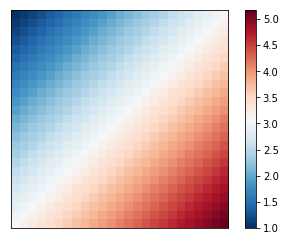

In [7]:
plt.imshow(B1, extent=[0,10, 0, 10], origin='lower',cmap='RdBu_r')
plt.colorbar()
plt.axis(aspect='image')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

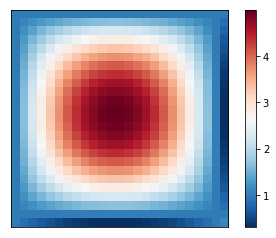

In [8]:
plt.imshow(B2, extent=[0,25, 0, 25], origin='lower',cmap='RdBu_r')
plt.colorbar()
plt.axis(aspect='image')
plt.xticks([])
plt.yticks([])

In [9]:
B0=B0.reshape(-1,1)
B1=B1.reshape(-1,1)
B2=B2.reshape(-1,1)

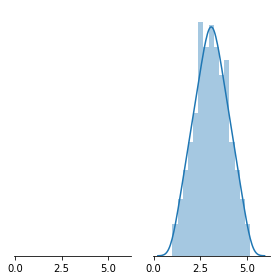

In [10]:
f, axes = plt.subplots(1, 2, figsize=(4, 4), sharex=True)
sns.despine(left=True)
sns.distplot(B0,ax=axes[0])
sns.distplot(B1,ax=axes[1])

plt.setp(axes, yticks=[])
plt.tight_layout()

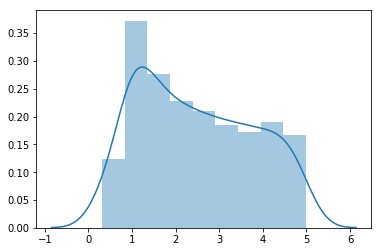

In [11]:
sns.distplot(B2)

In [12]:
lat=Y.reshape(-1,1)
lon=X.reshape(-1,1)

In [14]:
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)

In [55]:
param = np.hstack([B1,B2])

In [56]:
param.shape

(625, 2)

In [57]:
cons=np.ones_like(x1)

In [58]:
cons=cons.reshape(-1,1)

In [59]:
X=np.hstack([x1,x2])

In [60]:
X.shape

(625, 2)

In [61]:
#binomial y
y_exp = 1/(1+np.exp(-1*np.sum(X * param, axis=1).reshape(-1, 1)))

In [62]:
np.mean(y_exp)

0.48826701350366136

In [63]:
y_exp.shape

(625, 1)

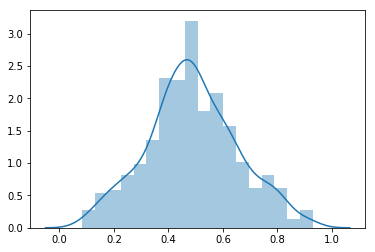

In [64]:
sns.distplot(y_exp)

In [65]:
def prob(y,ym):
    n=y.shape[0]
    for i in range(n):
        if y[i]>=0.5:
            ym[i]=1
        else:
            ym[i]=0
    return ym

In [66]:
ym=np.ones_like(y_exp)
y_new=prob(y_exp,ym)

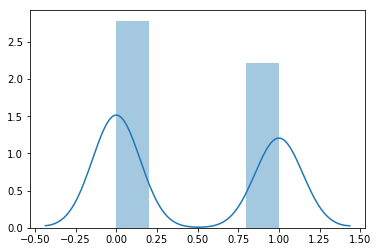

In [67]:
sns.distplot(y_new)

In [68]:
coords = np.array(list(zip(lon,lat)))
y = np.array(y_new).reshape((-1,1))
#y_std = (y-y.mean(axis=0))/y.std(axis=0)

In [69]:
X=np.hstack([x1,x2])
X_std = (X-X.mean(axis=0))/X.std(axis=0)

In [70]:
bw=Sel_BW(coords,y,X_std,family=Binomial(),constant=False)
bw=bw.search()
gwr_model=GWR(coords,y,X_std,bw,family=Binomial(),constant=False).fit()

In [71]:
bw

103.0

In [72]:
gwr_model.aic

165.71680977089486

In [73]:
selector=Sel_BW(coords,y,X_std,multi=True,family=Binomial(),constant=False)

In [74]:
selector.search(verbose=True)

Current iteration: 1 ,SOC: 0.0575755
Bandwidths: 624.0, 540.0
Current iteration: 2 ,SOC: 0.0005415
Bandwidths: 624.0, 540.0
Current iteration: 3 ,SOC: 7e-07
Bandwidths: 624.0, 540.0


array([624., 540.])

In [76]:
mgwr_model=MGWR(coords,y,X_std,selector,family=Binomial(),constant=False).fit()

In [79]:
mgwr_model.resid_ss,gwr_model.resid_ss

(106.50235052741388, 16.93406345293964)